In [3]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.recurrent import LSTM
from keras.backend import squeeze
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from data_loader import *
import tensorflow as tf
from keras.utils import multi_gpu_model

In [2]:
data_file = "/home/mshefa/training_data/training_data_chunk_0.pkl"
data = LoadModRecData(data_file, .9, .1, 0.)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [3]:
number_of_samples_in_instance = data.instance_shape[1]
data.modTypes

array(['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB',
       'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz',
       'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE',
       'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK'],
      dtype='<U11')

(1, 1024) 498
(1, 1024) 269
(1, 1024) 1504
(1, 1024) 479
(1, 1024) 1058
(1, 1024) 1011
(1, 1024) 1628
(1, 1024) 1900
(1, 1024) 1666
(1, 1024) 1460
(1, 1024) 1330
(1, 1024) 894
(1, 1024) 1623
(1, 1024) 1277
(1, 1024) 1481
(1, 1024) 1095
(1, 1024) 1796
(1, 1024) 1813
(1, 1024) 1718
(1, 1024) 1656
(1, 1024) 1701
(1, 1024) 1211


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(1, 1024) 270
(1, 1024) 1418


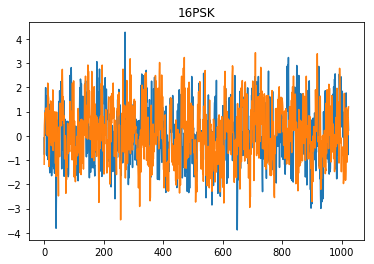

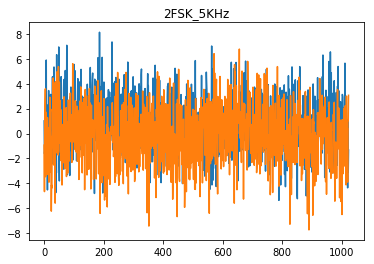

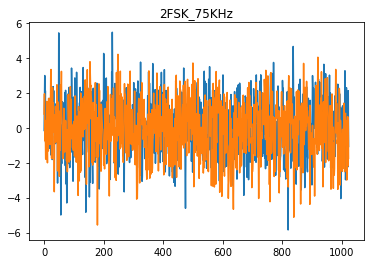

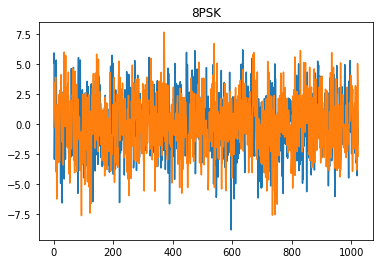

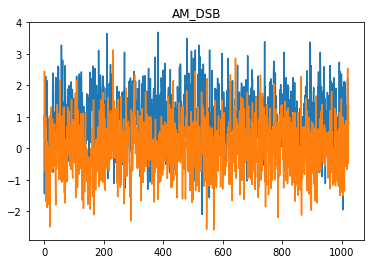

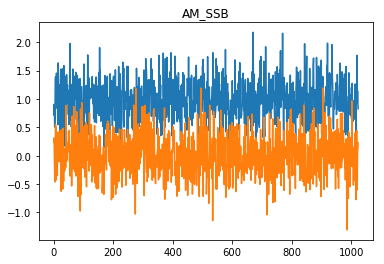

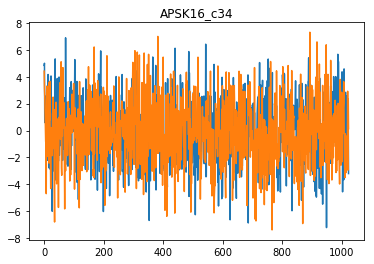

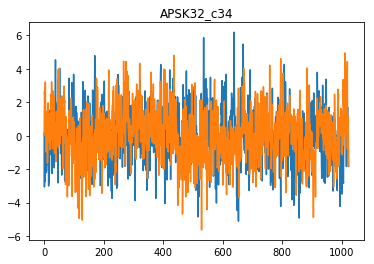

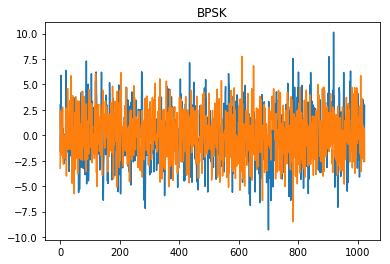

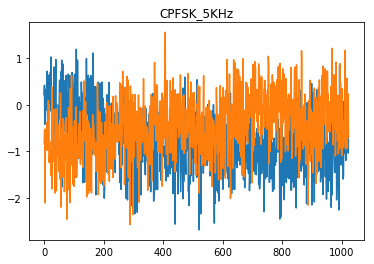

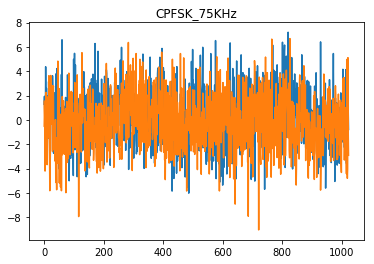

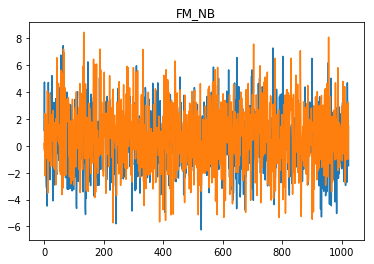

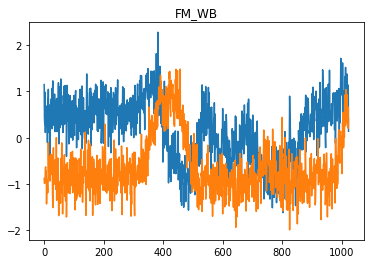

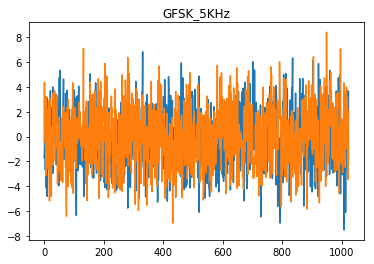

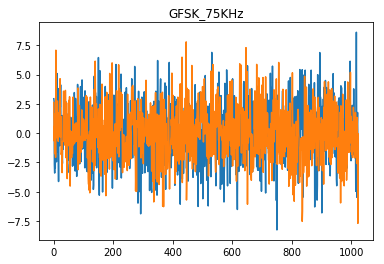

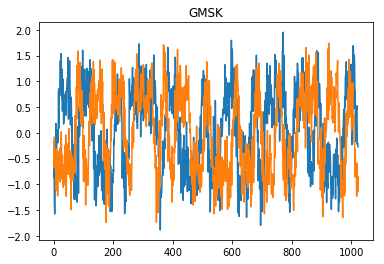

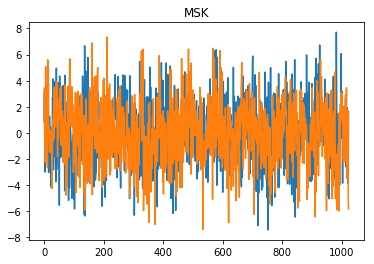

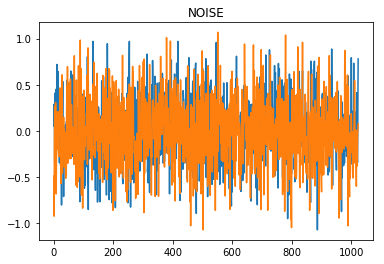

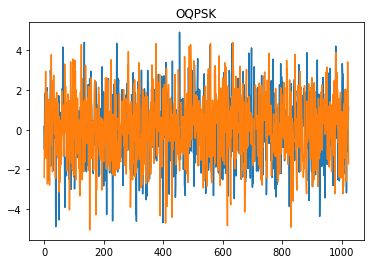

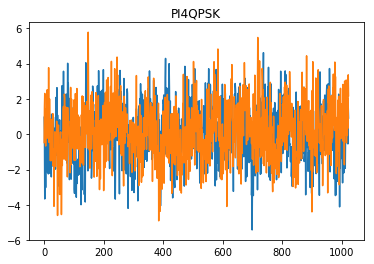

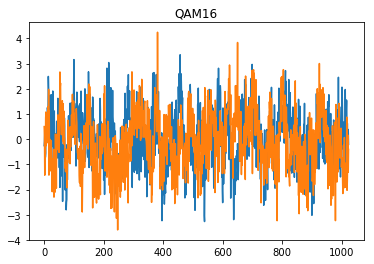

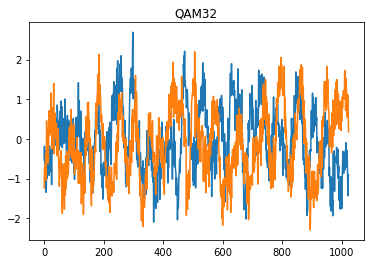

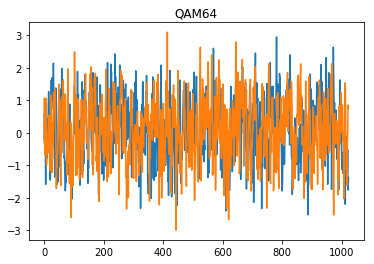

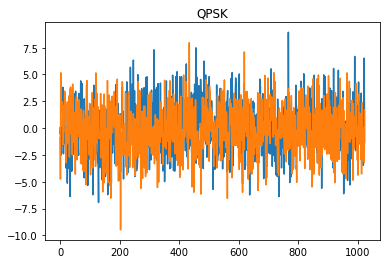

In [4]:
# for each modulation type, inspect some instances of data
for modType in data.modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()
    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

Using TensorFlow backend.


In [17]:
in_shp = [2,1024]
dr = 0.5 # dropout rate (%)
classes = data.modTypes
with tf.device("/cpu:0"):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(256, kernel_size=(1, 5), strides=(1,2), border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(80, kernel_size=(2, 3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    rshape = model.output_shape
    print(model.output_shape)
    model.add(Reshape([rshape[2],rshape[3]]))
    model.add(LSTM(64, return_sequences=True, name='lstm1'))
    model.add(LSTM(64, return_sequences=True, name='lstm2'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')

    

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(1, 5), strides=(1, 2), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, kernel_size=(2, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()


(None, 1, 514, 80)


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, name="dense2", kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 2, 1024, 1)        0         
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 2, 1028, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 512, 256)       1536      
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 512, 256)       0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 2, 516, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 514, 80)        122960    
_________________________________________________________________
reshape_28 (Reshape)         (None, 514, 80)           0         
__________

In [18]:
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
train_batch_size, number_of_epochs = 256, 10
tsteps = data.train_idx.size/train_batch_size
vsteps = data.val_idx.size/train_batch_size
train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)

history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# # we re-load the best weights once training is finished
# model.load_weights(filepath)

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1012.5, verbose=2, validation_data=<generator..., validation_steps=112.5, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10
 - 1107s - loss: 1.6953 - val_loss: 1.3517
Epoch 2/10


KeyboardInterrupt: 

NameError: name 'history' is not defined

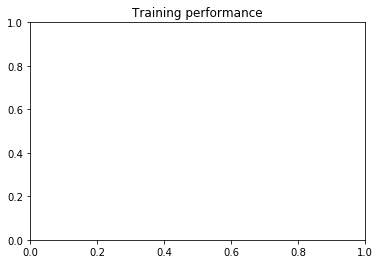

In [13]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_file = "/home/mshefa/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0., 0., 1.)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

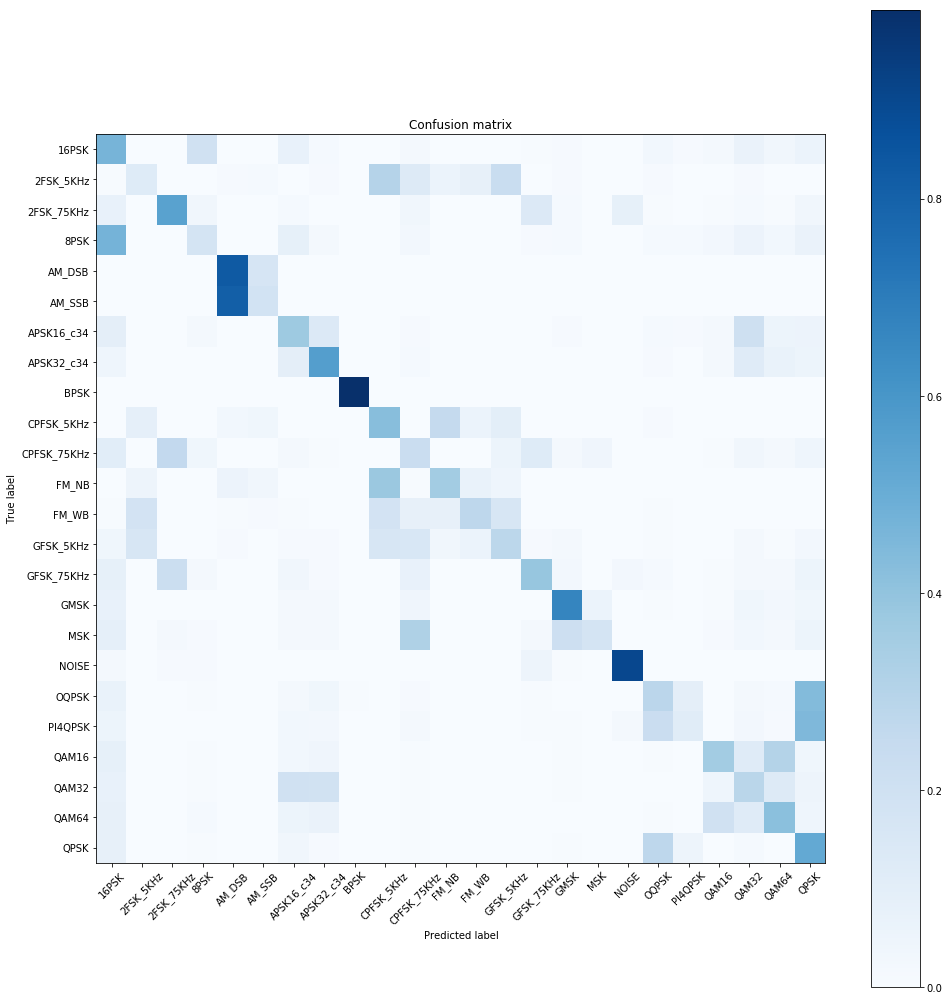

In [24]:
# Plot confusion matrix# Plot c 
X_test = testdata.signalData[data.test_idx]
Y_test = testdata.oneHotLabels[data.test_idx]
test_Y_hat = model.predict(X_test, batch_size=train_batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(14,14))
plot_confusion_matrix(confnorm, labels=classes)

SNR -15 Overall Accuracy:  0.19625 Out of 2400
SNR -10 Overall Accuracy:  0.23449571935685948 Out of 4789
SNR -5 Overall Accuracy:  0.4435517970401691 Out of 2365
SNR 0 Overall Accuracy:  0.4856909239574816 Out of 2446
SNR 5 Overall Accuracy:  0.540625 Out of 4800
SNR 10 Overall Accuracy:  0.5371308016877637 Out of 2370


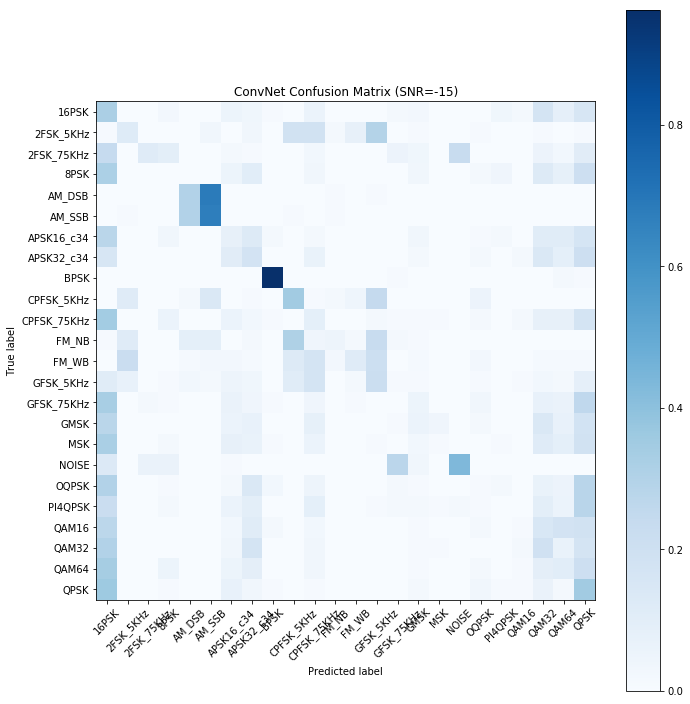

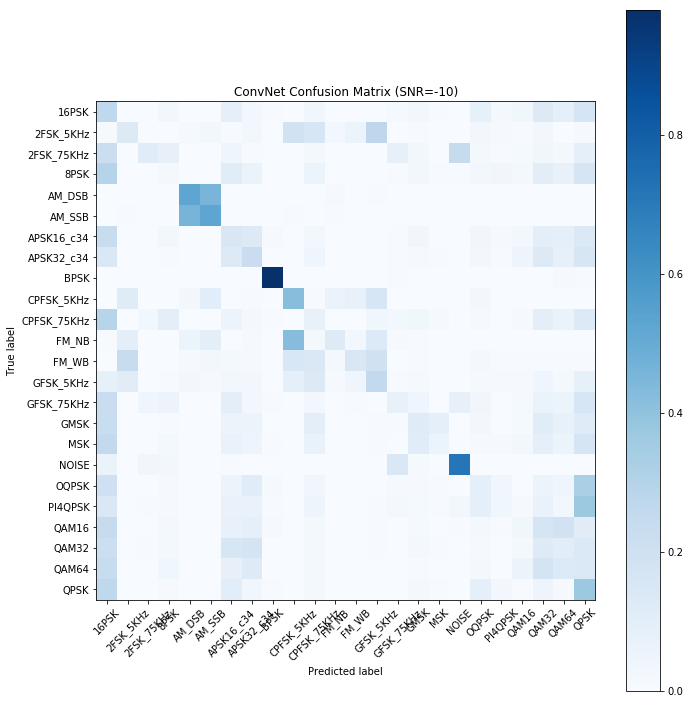

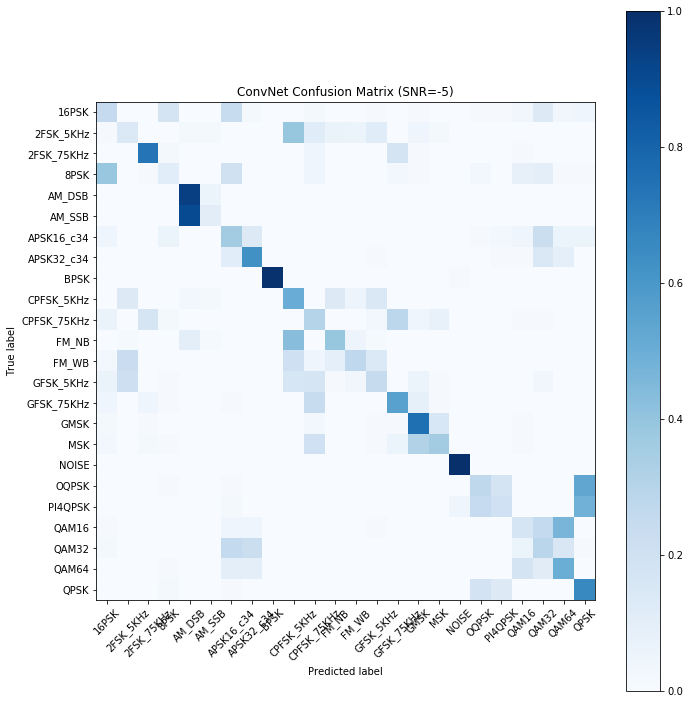

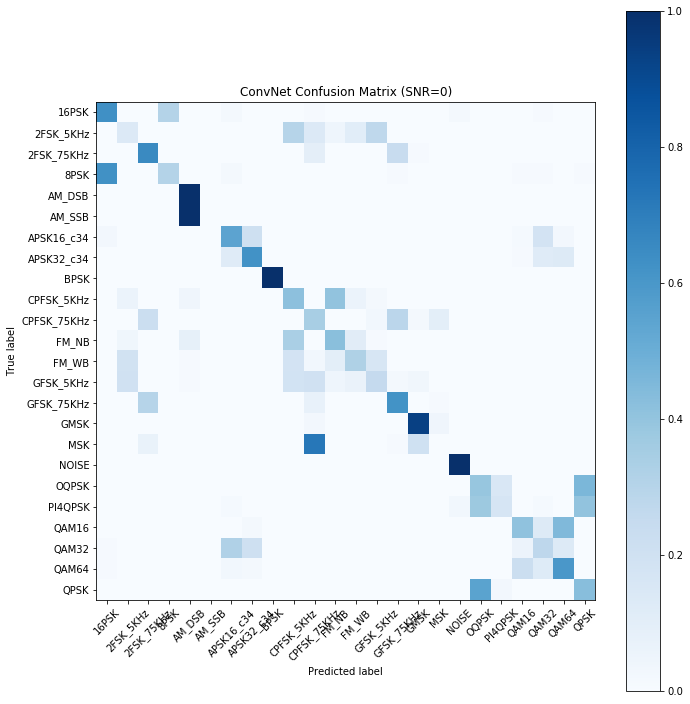

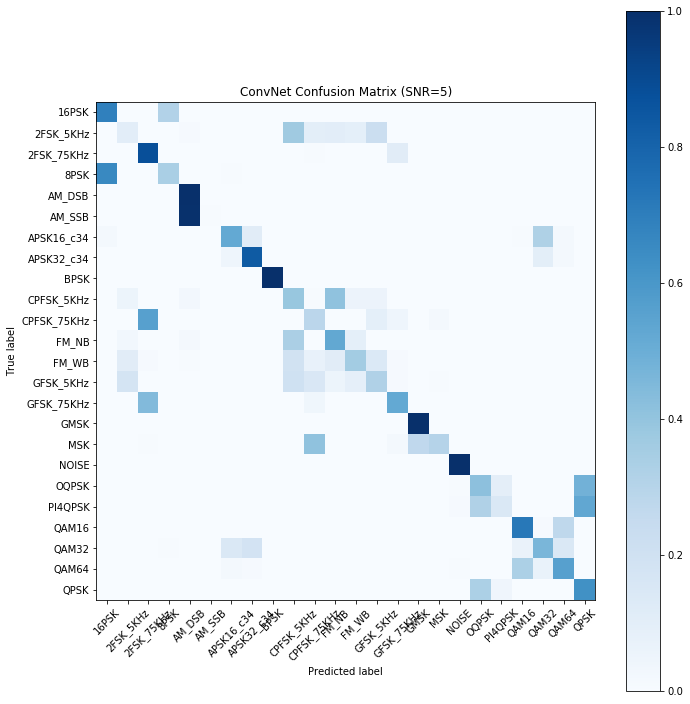

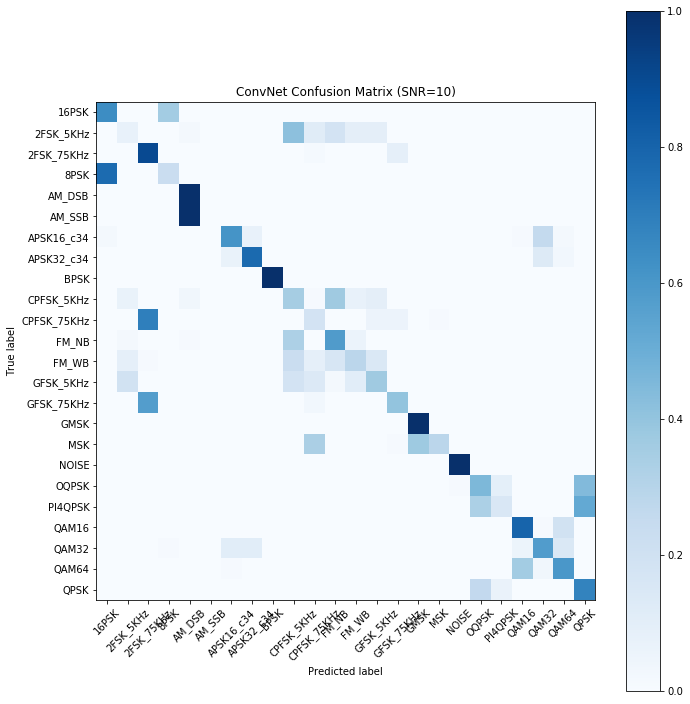

In [33]:

# Plot confusion matrix
acc = {}
snrs = np.arange(-15,15, 5)
for snr in snrs:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(data.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)

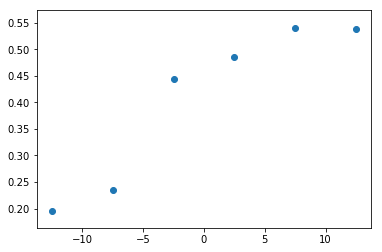

In [38]:
plt.scatter(np.array(list(acc.keys()))+2.5, list(acc.values()))

In [37]:
acc

{-15: 0.19625,
 -10: 0.23449571935685948,
 -5: 0.4435517970401691,
 0: 0.4856909239574816,
 5: 0.540625,
 10: 0.5371308016877637}

In [43]:
from keras.layers.recurrent import 

In [80]:
def get_params(size=10):
    
    f1, f2, f3, stride1, kernel1 = [], [], [], [], []
    for i in range(size):
        f1.append(random.randint(5,10))
        f2.append(random.randint(5, f1[-1]))
        f3.append(random.randint(5, 8))
        if np.random.random() > 0.5:
            s1 = (1,2)
        else:
            s1 = (1,1)
        if np.random.random() > 0.5:
            k1 = (1,5)
        else:
            k1 = (1,3)
        stride1.append(s1)
        kernel1.append(k1)
    f1 = 2**np.asarray(f1)
    f2 = 2**np.asarray(f2)
    f3 = 2**np.asarray(f3)
    return f1, f2, f3, stride1, kernel1
print(get_params(10))

def build_model(f1, f2, f3, kernel1, stride1, dr=0.5, in_shp=[2,1024]):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f1, kernel_size=kernel1, strides=stride1, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f2, kernel_size=(2,3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(f3, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
    return model

(array([ 128, 1024, 1024, 1024, 1024,  256,   32, 1024,  128,  128]), array([ 64, 512, 256, 128,  32,  32,  32, 512,  32,  32]), array([128, 256,  32,  32, 128,  32, 128, 128, 128,  32]), [(1, 2), (1, 1), (1, 2), (1, 1), (1, 2), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1)], [(1, 3), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 3), (1, 3)])


In [ ]:
from keras.layers.core import 